In [130]:
import yfinance as yf
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf


In [24]:
def get_btc_idr(time_from, time_to) :
    pair = 'BTCIDR'
    time_frame = '1D'
    return requests.get('https://indodax.com/tradingview/history_v2?from=' + str(time_from) + '&symbol=' + pair +'&tf=' + time_frame + '&to=' + str(time_to)).json()

In [63]:
now = datetime.now()
past = now - timedelta(days=5*365)
time_from_s = int(time.mktime(past.timetuple()))
time_to_s = int(time.mktime(now.timetuple()))
time_from_date = past.strftime('%Y-%m-%d')
time_to_date = now.strftime('%Y-%m-%d')

In [121]:
def get_df_btc_idr(time_from, time_to) :
    btc_idr_daily = get_btc_idr(time_from, time_to)
    df_daily = pd.DataFrame(btc_idr_daily)
    if df_daily.empty :
        return df_daily
    df_daily['Date'] = pd.to_datetime(df_daily['Time'], unit='s')
    df_daily = df_daily.sort_values(by='Date')
    df_daily.set_index('Date', inplace=True)
    df_weekly = df_daily.resample('W-FRI').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    df_weekly.reset_index(inplace=True)
    return df_weekly

In [122]:
df_btc_idr = get_df_btc_idr(time_from_s, time_to_s)
print(df_btc_idr)

          Date        Open        High         Low       Close         Volume
0   2020-04-10   118962000   119042000   105139000   105350000  2713.74779928
1   2020-04-17   105150000   112624000   104199000   110757000  2032.34160435
2   2020-04-24   110855000   134600000   109688000   133000000  2676.88878745
3   2020-05-01   132999000   140800000   126965000   138605000  3466.30151257
4   2020-05-08   138602000   150000000   127517000   138884000  4156.65295898
..         ...         ...         ...         ...         ...            ...
257 2025-03-14  1379247000  1435000000  1316480000  1431900000   176.53093356
258 2025-03-21  1434896000  1470000000  1380324000  1452115000   185.49720136
259 2025-03-28  1452115000  1459590000  1359998000  1392322000   218.97392859
260 2025-04-04  1392322000  1417646000  1280000000  1383247000   352.68976949
261 2025-04-11  1383248000  1390000000  1330020000  1361201000    51.41660537

[262 rows x 6 columns]


In [141]:
ticker_symbol = 'DCII.JK'

In [124]:
def get_df_stock_idr(ticker, time_from, time_to) :
    stock_daily = yf.download(ticker, start=time_from, end=time_to, interval='1d', multi_level_index=False)
    stock_weekly = stock_daily.resample('W-FRI').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    stock_weekly.dropna(inplace=True)
    stock_weekly.reset_index(inplace=True)
    return stock_weekly

In [161]:
df_bbca_idr = get_df_stock_idr(ticker_symbol, time_from_s, time_to_s)
print(df_bbca_idr)

[*********************100%***********************]  1 of 1 completed

          Date      Open      High       Low     Close   Volume
0   2021-01-08     525.0     815.0     525.0     815.0     4700
1   2021-01-15    1015.0    2460.0    1015.0    2460.0    90300
2   2021-01-22    2820.0    4780.0    2820.0    4780.0  1428700
3   2021-01-29    4780.0    7150.0    4780.0    7150.0   597400
4   2021-02-05    7700.0   10275.0    6925.0    8250.0  1801500
..         ...       ...       ...       ...       ...      ...
215 2025-03-07  116125.0  154500.0  116125.0  154500.0    29100
216 2025-03-14  169950.0  226150.0  169950.0  180925.0    62600
217 2025-03-21  144750.0  200050.0   92650.0  152025.0   308700
218 2025-03-28  152100.0  177300.0  138950.0  167950.0   114100
219 2025-04-11  142775.0  162000.0  142775.0  154100.0    35600

[220 rows x 6 columns]


In [143]:
def get_history_btc_pair(stock_ticker, df_stock_idr_weekly, df_btc_idr_weekly) :
    ticker_name_low = stock_ticker.lower()
    df_merged = pd.merge(df_stock_idr_weekly, df_btc_idr_weekly, on='Date', suffixes=('_'+ticker_name_low, '_btc'))
    df_merged['Open_' + ticker_name_low +'_btc'] = df_merged['Open_' + ticker_name_low] / df_merged['Open_btc']
    df_merged['High_' + ticker_name_low +'_btc'] = df_merged['High_' + ticker_name_low] / df_merged['High_btc']
    df_merged['Low_' + ticker_name_low + '_btc'] = df_merged['Low_' + ticker_name_low] / df_merged['Low_btc']
    df_merged['Close_'+ ticker_name_low +'_btc'] = df_merged['Close_' + ticker_name_low] / df_merged['Close_btc']
    df_merged['Volume_'+ ticker_name_low +'_btc'] = df_merged['Volume_' + ticker_name_low]

    df_final = df_merged[['Date', 'Open_' + ticker_name_low +'_btc', 'High_' + ticker_name_low +'_btc', 'Low_' + ticker_name_low + '_btc', 'Close_' + ticker_name_low +'_btc', 'Volume_' + ticker_name_low +'_btc']].copy()
    df_final.rename(columns={
        'Open_' + ticker_name_low +'_btc': 'Open',
        'High_' + ticker_name_low +'_btc': 'High',
        'Low_' + ticker_name_low + '_btc': 'Low',
        'Close_' + ticker_name_low +'_btc': 'Close',
        'Volume_' + ticker_name_low +'_btc': 'Volume'
    }, inplace=True)
    return df_final

In [160]:
df_bbca_btc = get_history_btc_pair(ticker_symbol, df_bbca_idr, df_btc_idr)
print(df_bbca_btc)

          Date      Open      High       Low     Close   Volume
0   2021-01-08  0.000001  0.000001  0.000001  0.000002     4700
1   2021-01-15  0.000002  0.000004  0.000002  0.000005    90300
2   2021-01-22  0.000006  0.000009  0.000007  0.000011  1428700
3   2021-01-29  0.000011  0.000014  0.000011  0.000014   597400
4   2021-02-05  0.000015  0.000015  0.000014  0.000013  1801500
..         ...       ...       ...       ...       ...      ...
215 2025-03-07  0.000079  0.000102  0.000092  0.000112    29100
216 2025-03-14  0.000123  0.000158  0.000129  0.000126    62600
217 2025-03-21  0.000101  0.000136  0.000067  0.000105   308700
218 2025-03-28  0.000105  0.000121  0.000102  0.000121   114100
219 2025-04-11  0.000103  0.000117  0.000107  0.000113    35600

[220 rows x 6 columns]


In [162]:
def show_candlestick(ticker, df_stock_btc):
    df_stock_btc.set_index('Date', inplace=True)
    mpf.plot(df_stock_btc, type='candle', style='binance', title=ticker+' Weekly Pair BTC', ylabel='Harga (BTC)', volume=True)

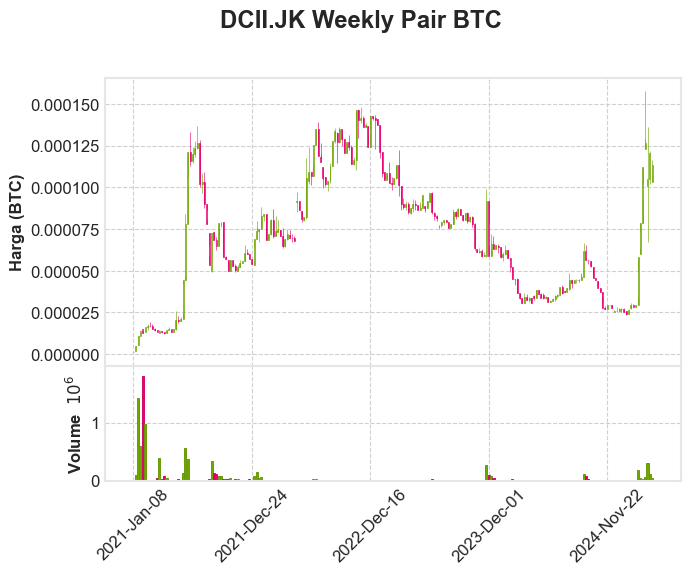

In [163]:
show_candlestick(ticker_symbol, df_bbca_btc)